In [1]:
#Mounting on co-lab
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,'/content/drive/My Drive/Interpretable_DNN') # change folder name

Mounted at /content/drive


In [2]:
#Import of Libaries

import os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy.ma.core import argmax

#Data Preprocessing
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.cluster import KMeans


#Model Building and Explanations
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend, Model, callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


#custom functions
from functions.data_proc import *
from functions.experiment_setup import *
from functions.generate_inputs import *


In [3]:


#Directories
MY_WORKSPACE_DIR = "/content/drive/My Drive/Interpretable_DNN/BPIC12"

#Dataset
file_name = os.path.join(MY_WORKSPACE_DIR,'BPIC_2012_MILESTONE_BASED_OUTCOME_EXTENDED.csv')
log_name = 'bpic_2012'




In [4]:

log_df = pd.read_csv(file_name)
log_df = log_df.reset_index(drop=True)
log_df = log_df.iloc[:,:10]

In [5]:
log_df.head()

CASEID          MILESTONE  RESOURCE  TASK_DURATION  TIME_ELAPSED  \
0  173688  A_PARTLYSUBMITTED     112.0              0             0   
1  173688        A_SUBMITTED     112.0              0             0   
2  173688      A_PREACCEPTED     112.0              1             0   
3  173688         A_ACCEPTED   10862.0            663             1   
4  173688        A_FINALIZED   10862.0              0           667   

                        END_TIMESTAMP  ACTIVITY_INDEX  AMOUNT_REQ     OUTCOME  \
0  2011-10-01 08:38:44.8800000 +10:00               1       20000  A_APPROVED   
1  2011-10-01 08:38:44.5460000 +10:00               2       20000  A_APPROVED   
2  2011-10-01 08:39:37.9060000 +10:00               3       20000  A_APPROVED   
3  2011-10-01 19:42:43.3080000 +10:00               4       20000  A_APPROVED   
4  2011-10-01 19:45:09.2430000 +10:00               5       20000  A_APPROVED   

   TRACE_END  
0          0  
1          0  
2          0  
3          0  
4          0

#### How early should be the prediction

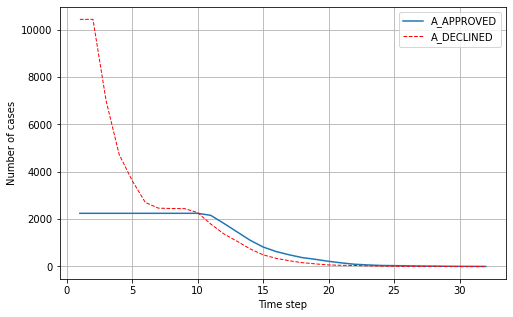

In [6]:
# How predictable is the outcome as we move along the trace

df_t = log_df.groupby(['ACTIVITY_INDEX','OUTCOME'])['CASEID'].size().reset_index()
x = df_t['ACTIVITY_INDEX'].unique()
y_0 = df_t[df_t['OUTCOME'] == 'A_APPROVED']['CASEID']
y_1 = df_t[df_t['OUTCOME'] == 'A_DECLINED']['CASEID']


plt.figure(num = 3, figsize=(8, 5))
plt.plot(x, y_0 ,label = 'A_APPROVED')
plt.plot(x, y_1, 
         color='red',   
         linewidth=1.0,  
         linestyle='--',
         label = 'A_DECLINED' 
        )
plt.xlabel('Time step')
plt.ylabel('Number of cases')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

In [11]:
#Entropy of the prediction along the trace
df_t = log_df.groupby(['ACTIVITY_INDEX','OUTCOME'])['CASEID'].size().reset_index()
df_t = df_t.pivot(index='ACTIVITY_INDEX',columns = 'OUTCOME', values = 'CASEID').reset_index()
df_t['P_A_APPROVED'] = df_t['A_APPROVED']/(df_t['A_APPROVED']+df_t['A_DECLINED'])
df_t['P_A_DECLINED'] = df_t['A_DECLINED']/(df_t['A_APPROVED']+df_t['A_DECLINED'])

df_t['ENTROPY'] = - (df_t['P_A_APPROVED']*np.log2(df_t['P_A_APPROVED'])+ df_t['P_A_DECLINED']*np.log2(df_t['P_A_DECLINED']))

plt.figure(num = 3, figsize=(8, 5))
x = df_t['ACTIVITY_INDEX']
y = df_t['ENTROPY']
plt.plot(x, y)
plt.xlabel('Time step')
plt.ylabel('Entropy of the outcome')
plt.grid(True)
plt.show()


In [12]:
color_p = sn.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)


In [13]:
# Distribution of the time spent on each case by the timestep

#bx = log_df.boxplot(column = 'TIME_ELAPSED', by = 'ACTIVITY_INDEX' )

plt.figure(figsize=(15,8))
ax = sn.boxplot(x='ACTIVITY_INDEX', y='TIME_ELAPSED', palette='GnBu_r', data=log_df, showfliers = False)

In [14]:
#distribution of activity counts by the timestep

df_t = log_df.groupby(['ACTIVITY_INDEX','MILESTONE'])['CASEID'].size().reset_index()
df_t = df_t.pivot(index='ACTIVITY_INDEX',columns = 'MILESTONE', values = 'CASEID')
df_t = df_t.fillna(0)


In [15]:
df_t.columns

Index(['A_ACCEPTED', 'A_FINALIZED', 'A_PARTLYSUBMITTED', 'A_PREACCEPTED',
       'A_SUBMITTED', 'O_CANCELLED', 'O_SENT', 'O_SENT_BACK',
       'W_ASSESSING_APPLICATION', 'W_COMPLETE_LEADS',
       'W_COMPLETE_PREACCEPTED_APPLICATIONS', 'W_FOLLOWUP_MISSING_INFO',
       'W_FOLLOWUP_OFFER', 'W_INVESTIGATING_FOR_FRAUD'],
      dtype='object', name='MILESTONE')

In [16]:
col = ['A_PARTLYSUBMITTED','A_SUBMITTED','A_PREACCEPTED','W_COMPLETE_LEADS','W_COMPLETE_PREACCEPTED_APPLICATIONS','A_ACCEPTED','A_FINALIZED','O_SENT','W_ASSESSING_APPLICATION',
'W_FOLLOWUP_MISSING_INFO','W_FOLLOWUP_OFFER','W_INVESTIGATING_FOR_FRAUD','O_SENT_BACK','O_CANCELLED']


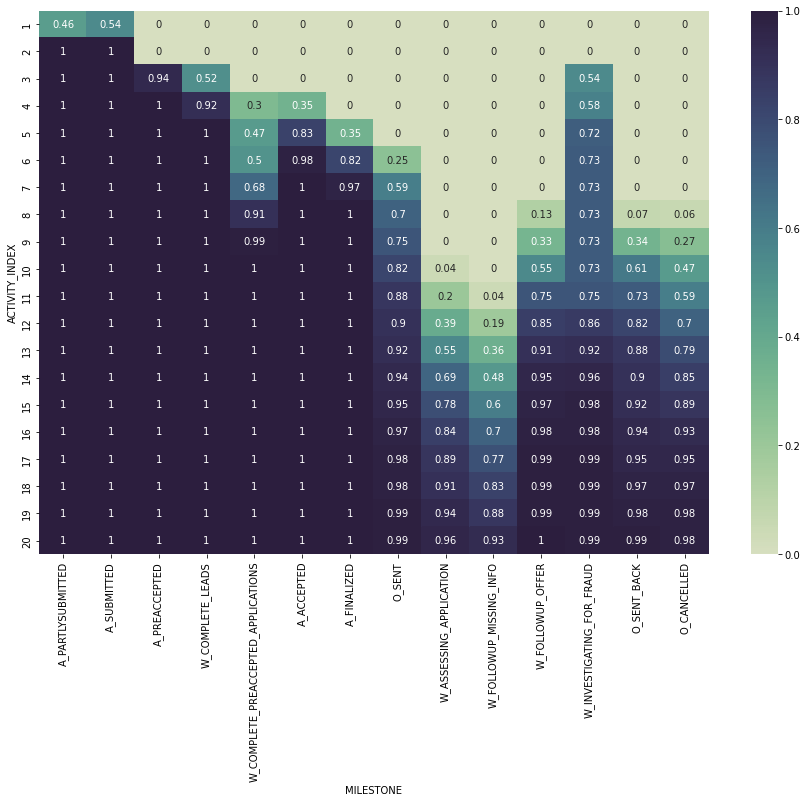

In [17]:
df_a = df_t[col]
df_a = round(df_a.cumsum()/df_a.sum(),2)
df_a = df_a.iloc[:20]
plt.figure(figsize=(15,10))
ax = sn.heatmap(df_a, cmap=color_p ,annot=True, fmt="g")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text major ticklabel objects>)

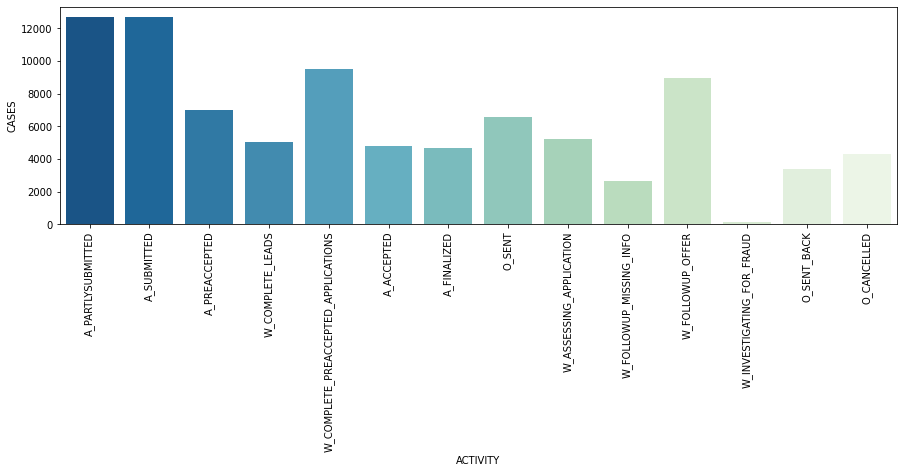

In [18]:
df_b = df_t[col]
df_b = df_b.sum().reset_index()
df_b.columns = ['ACTIVITY','CASES']
plt.figure(figsize=(15,4))
ax = sn.barplot(data=df_b, x='ACTIVITY', y='CASES',palette='GnBu_r')
plt.xticks(rotation=90)


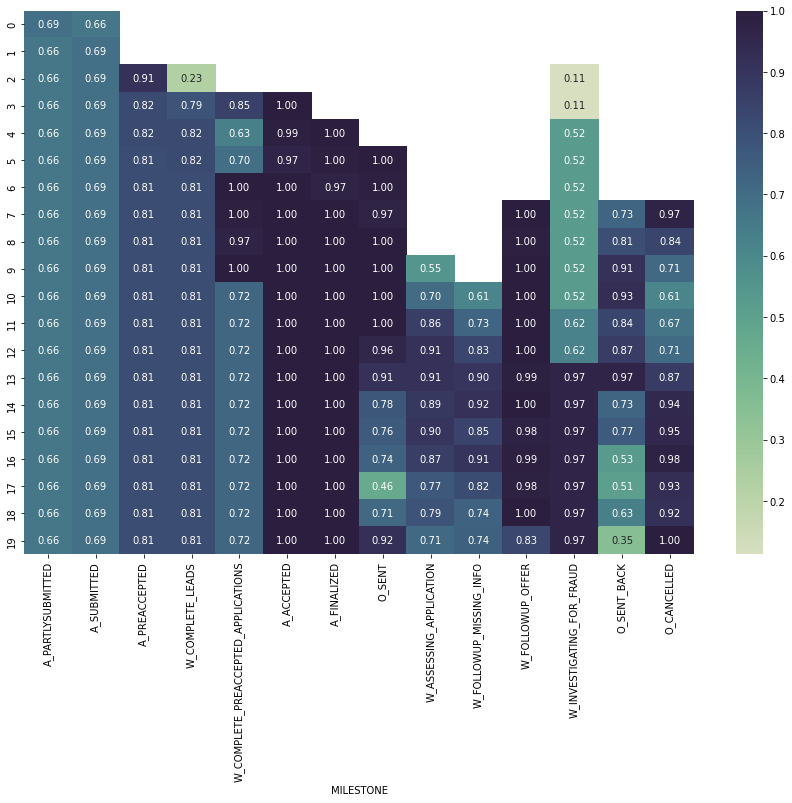

In [25]:
#Entropy of Each Feature
df_t = log_df.groupby(['ACTIVITY_INDEX','MILESTONE','OUTCOME'])['CASEID'].size().reset_index()
df_t = df_t.pivot(index=['ACTIVITY_INDEX','MILESTONE'],columns = 'OUTCOME', values = 'CASEID').reset_index()
df_t = df_t.fillna(0)

#compute entropy for each feature at each step
df_t['P_A_APPROVED'] = df_t['A_APPROVED']/(df_t['A_APPROVED']+df_t['A_DECLINED'])
df_t['P_A_DECLINED'] = df_t['A_DECLINED']/(df_t['A_APPROVED']+df_t['A_DECLINED'])

df_t['ENTROPY'] = - (df_t['P_A_APPROVED']*np.log2(df_t['P_A_APPROVED'])+ df_t['P_A_DECLINED']*np.log2(df_t['P_A_DECLINED']))

#pivoting by activity
df_t = df_t.pivot(index='ACTIVITY_INDEX',columns = 'MILESTONE', values = 'ENTROPY').reset_index()
df_a = df_t[col]
df_a = df_a.fillna(0)
df_a = df_a.replace(to_replace=0, method='ffill')
df_a.replace(0, np.nan, inplace=True)
df_a = df_a.iloc[:20]
plt.figure(figsize=(15,10))
ax = sn.heatmap(df_a, cmap=color_p ,annot=True, fmt=".2f")





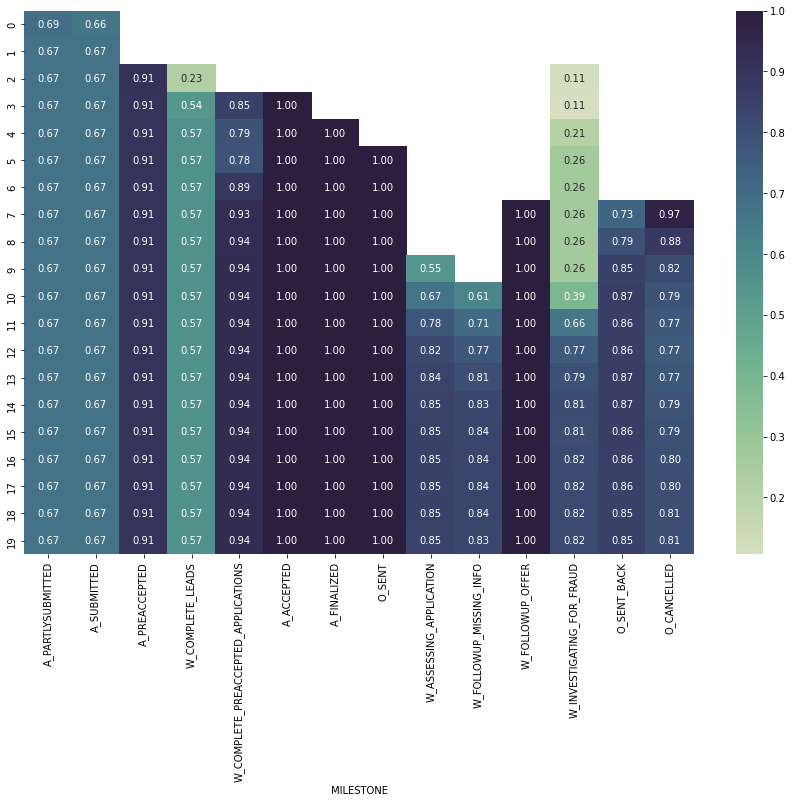

In [32]:
#Entropy of Each Feature
df_t = log_df.groupby(['ACTIVITY_INDEX','MILESTONE','OUTCOME'])['CASEID'].size().reset_index()
df_t = df_t.pivot(index=['ACTIVITY_INDEX'],columns = ['OUTCOME','MILESTONE'], values = 'CASEID').reset_index()
df_t = df_t.fillna(0)

#number of traces which has a given activity on or before the given activity index
df_t = df_t.cumsum()
df_t = df_t.stack().reset_index().fillna(0)
df_t['ACTIVITY_INDEX'] = df_t['level_0']+1
df_t = df_t.iloc[:,1:]

#computation of entropy
df_t['P_A_APPROVED'] = df_t['A_APPROVED']/(df_t['A_APPROVED']+df_t['A_DECLINED'])
df_t['P_A_DECLINED'] = df_t['A_DECLINED']/(df_t['A_APPROVED']+df_t['A_DECLINED'])

df_t['ENTROPY'] = - (df_t['P_A_APPROVED']*np.log2(df_t['P_A_APPROVED'])+ df_t['P_A_DECLINED']*np.log2(df_t['P_A_DECLINED']))

#pivoting by activity
df_t = df_t.pivot(index='ACTIVITY_INDEX',columns = 'MILESTONE', values = 'ENTROPY').reset_index()

#plot
df_a = df_t[col]
df_a = df_a.iloc[:20]
plt.figure(figsize=(15,10))
ax = sn.heatmap(df_a, cmap=color_p ,annot=True, fmt=".2f")



<ipython-input-15-4f76ccaa9367>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(cor, dtype=np.bool))


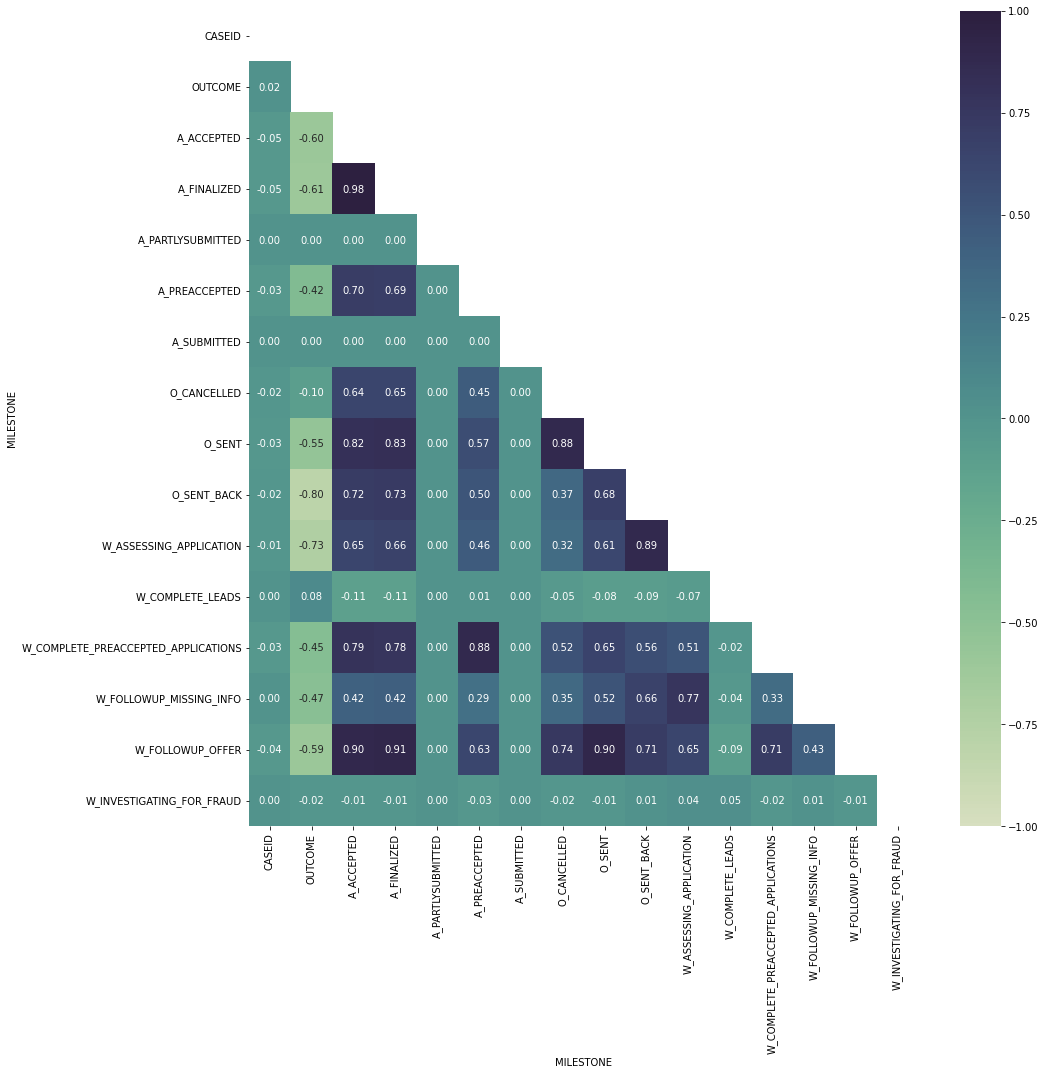

In [ ]:
#Outcome vs occurance of an activity in the trace

df_t1 = log_df.groupby(['CASEID','MILESTONE','OUTCOME'])['ACTIVITY_INDEX'].size().reset_index()
df_t1 = df_t1.pivot(index=['CASEID','OUTCOME'],columns = 'MILESTONE', values = 'ACTIVITY_INDEX').reset_index() 

df_t1['OUTCOME'] = df_t1['OUTCOME'].map({'A_DECLINED': 1,'A_APPROVED':0})
df_t1 = df_t1.fillna(0)

cor = df_t1.corr()
cor = cor.fillna(0)
mask = np.triu(np.ones_like(cor, dtype=np.bool))

plt.figure(figsize=(15,15))
ax = sn.heatmap(cor, cmap=color_p, mask = mask, annot=True, fmt='.2f',vmin=-1, vmax=1)